Code implementation for sequential change point detection using classical and online convex algorithms. We will follow the paper -'Sequential Change-Point Detection via Online Convex Optimization' (https://www.mdpi.com/1099-4300/20/2/108)

In [1]:
import numpy as np
from numpy import linalg as LA
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from scipy.linalg import sqrtm
from numpy.linalg import matrix_rank
from jax.numpy import linalg as jla
from scipy.linalg import logm, expm
from google.colab import files
from scipy.linalg import block_diag
import copy
import numba
from numba import int64, float64, jit, njit, vectorize
import matplotlib.pyplot as plt
import networkx as nx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

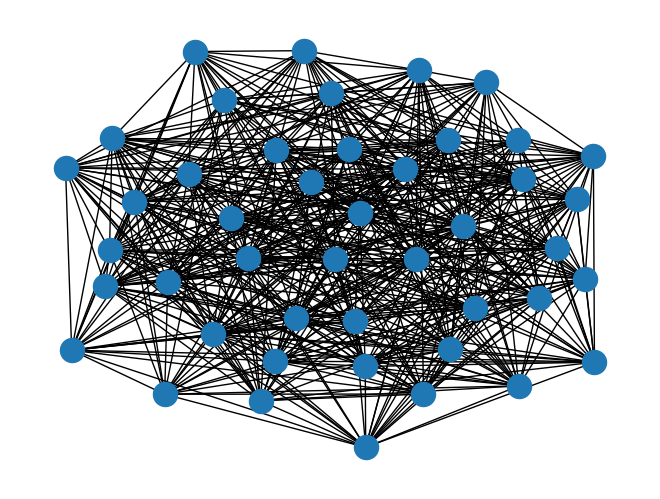

In [2]:
G= nx.erdos_renyi_graph(45,0.53)
nx.draw(G, with_labels=False)
plt.savefig("ergraph_0.2_n=100.pdf",bbox_inches='tight')
files.download("ergraph_0.2_n=100.pdf")
plt.show()

Compute Negative Log Likelihood

In [4]:


def bernouli_log_likelihood(x,t):

  '''
  function to compute negative log likelihood for bernouli RV
  '''
  return -np.sum(x*t)+np.sum(np.log(1+np.exp(t)))

def normal_log_likelihood(x,u):
  '''
  function to compute negative log likelihood for multivariable Gaussian
  '''
  return 0.5*(x-u)@(x-u)


Code to detect change point for mean shift in Gaussian distribution using CUSUM

In [7]:
def cusum_normal(samples,pre_mean,b,post_mean=1):
  x=samples
  l=len(samples)
  stat=np.zeros(l)
  u0=pre_mean
  u1=post_mean*np.ones(len(u0))
  i=0
  while(stat[i]<b and i<l-1):
    i=i+1
    stat[i]=max(stat[i-1]+normal_log_likelihood(x[i],u0)-normal_log_likelihood(x[i],u1),0)
  return i,stat




Sample Code to detect mean shift

In [9]:
x0=np.random.normal(0,1,500)
x1=np.random.normal(0.25,1,500)
x=np.concatenate([x0,x1])
g=np.array(range(len(x)))
st,stat=cusum_normal(x,np.array([0]),10,0.25)
print(st)

999


In [10]:
!pip install tikzplotlib
import tikzplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.2 MB/s eta 0:00:00


Plot samples from Gaussian distribution before and after mean shift

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

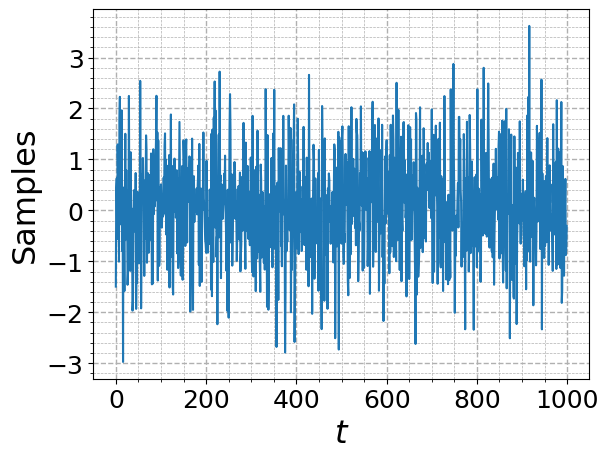

In [11]:
import matplotlib.pyplot as pl
pl.plot(g,x,linestyle='-',markersize=7.5)
pl.xticks(fontsize=18)

pl.yticks(fontsize=18)
pl.grid(which='major',linestyle='--',linewidth=1)
pl.grid(which='minor', linestyle='--', linewidth='0.5')
pl.minorticks_on()

pl.xlabel(r'$t$' ,fontsize=23)
pl.ylabel('Samples',fontsize=23)
pl.savefig("normal_samples.pdf",bbox_inches='tight')
tikzplotlib.save("normal_samples.tex")
files.download("normal_samples.tex")
#files.download("normal_samples.pdf")
pl.show()

Detecting mean shift using CUSUM

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

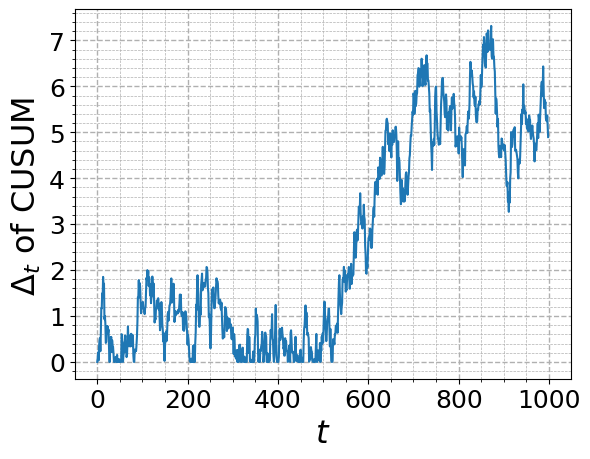

In [12]:
g1=np.array(range(st))
pl.plot(g1,stat[0:st],linestyle='-',markersize=7.5)
pl.xticks(fontsize=18)

pl.yticks(fontsize=18)
pl.grid(which='major',linestyle='--',linewidth=1)
pl.grid(which='minor', linestyle='--', linewidth='0.5')
pl.minorticks_on()

pl.xlabel(r'$t$' ,fontsize=23)
pl.ylabel('$\Delta_t$ of CUSUM ',fontsize=23)
pl.savefig("normal_CUSUM.pdf",bbox_inches='tight')
tikzplotlib.save("normal_CUSUM.tex")
files.download("normal_CUSUM.tex")
pl.show()

Compute sample $X_t$ as communication pattern with $i$th element being one indicates edge $i$ present in the Graph at time $t$

In [13]:
def generate_com_pattern(num_vertices,post_change_length,post_p,pre_p):
  '''
  function to generate communication pattern
  input :
       num_vertices=number of vertices
       post_change_length=cardinality of subset E
       post_p=post change probability for E
       pre_p=pre change probability

  output:
      communication pattern for edges
  '''
  d=num_vertices
  pt=post_change_length
  p0=pre_p
  p1=post_p
  x1=np.random.binomial(pt,p1)
  #print(x1)
  x=np.zeros(d)
  x[0:x1]=1
  x0=np.random.binomial(d-pt,p0)
  #print(x0)
  x[pt:pt+x0]=1
  return x

Detecting change in communication pattern using CUSUM

In [14]:
def cusum(num_vertices,post_change_length,post_p,pre_p,b,change_time=0):

  '''
  function to compute change point for communication rate model using CUSUM
  input :
       num_vertices=number of vertices
       post_change_length=cardinality of subset E
       post_p=post change probability for E
       pre_p=pre change probability
       b=threshold
       change_time= change time for model (default set to 0)

  output:
      change point detected using CUSUM
  '''
  st=0
  d=num_vertices
  pt=post_change_length
  p0=pre_p
  p1=post_p
  t0=np.log(p0/(1-p0))*np.ones(d)
  t1=np.log(p1/(1-p1))*np.ones(d)
  x=generate_com_pattern(num_vertices,post_change_length,post_p,pre_p)
  o=0
  while(st< b):
    if o>=change_time:
      x=generate_com_pattern(num_vertices,post_change_length,post_p,pre_p)
      st=max(st+bernouli_log_likelihood(x,t0)-bernouli_log_likelihood(x,t1),10**(-6))
      o=o+1
    else:
      x=generate_com_pattern(num_vertices,0,post_p,pre_p)
      st=max(st+bernouli_log_likelihood(x,t0)-bernouli_log_likelihood(x,t1),10**(-6))
      o=o+1



    #print(st)
    # if np.mod(o,100)==0:
    #   print(o)
  return o


Code to find expected detection delay for CUSUM using Monte Carlo

In [28]:
def mc_cusum(num_times,num_vertices,post_change_length,post_p,pre_p,b,change_time=0):
  o=np.zeros(num_times)
  for i in range(num_times):
    o[i]=cusum(num_vertices,post_change_length,post_p,pre_p,b,change_time)
  return sum(o)/num_times


In [115]:
o=mc_cusum(100,190,78,0.8,0.2,10,0)
print(o)

183.41


Detecting change in communication pattern using ACM

In [44]:
def acm(num_vertices,post_change_length,post_p,pre_p,b,window,epsilon,change_time=0):
  '''
  function to compute change point for communication rate model using CUSUM
  input :
       num_vertices=number of vertices
       post_change_length=cardinality of subset E
       post_p=post change probability for E
       pre_p=pre change probability
       b=threshold
       window=window for not blowing up the complexity
       epsilon=epsilon to saturate dual update
       change_time= change time for model (default set to 0)

  output:
      change point detected using ACM
  '''
  d=num_vertices
  pt=post_change_length
  p0=pre_p
  p1=post_p
  t0=np.log(p0/(1-p0))*np.ones(d)
  w=window
  t=np.zeros((w,d))
  mu=np.zeros((w,d))
  eta=np.zeros(w)
  st=[0]
  s=-10**(-8)*np.ones(w)
  x1=[]

  i=0
  while(st[i]<b):
    i=i+1
    if i>=change_time:
      x=generate_com_pattern(num_vertices,post_change_length,post_p,pre_p)
      x1.append(x)
    else:
      x=generate_com_pattern(num_vertices,0,post_p,pre_p)
      x1.append(x)

    index=0
    t[index]=t0
    s[index]=0
    eta[index]=1
    if i>w:
      for j in range(i-w,i-1):
        index=index+1
        s[index]=s[index-1]+bernouli_log_likelihood(x1[j],t0)-bernouli_log_likelihood(x1[j],t[index-1])
        mu[index-1]=np.divide(np.exp(t[index-1]),1+np.exp(t[index-1]))
        eta[index]=eta[index-1]+1
        #print(eta[index])
        mu[index]=mu[index-1]-(1/eta[index])*(mu[index-1]-x1[j])
        #print(mu[index])
        mu[index][mu[index]>epsilon]=epsilon
       # print(mu[index])
        mu[index][mu[index]<-epsilon]=-epsilon
        t[index]=np.log(np.divide(mu[index],1-mu[index]))
        if np.mod(i,20)==0:
          a=t[index]
          #print(a,np.count_nonzero(a>=0))

    else:
      for j in range(1,i):
        index=index+1
        s[index]=s[index-1]+bernouli_log_likelihood(x1[j],t0)-bernouli_log_likelihood(x1[j],t[index-1])
        #print(s[index],index)
        mu[index-1]=np.divide(np.exp(t[index-1]),1+np.exp(t[index-1]))
        #print(mu[index])
        eta[index]=eta[index-1]+1
        #print(eta[index])
        mu[index]=mu[index-1]-(1/eta[index])*(mu[index-1]-x1[j])
        #print(mu[index])
        mu[index][mu[index]>epsilon]=epsilon
        mu[index][mu[index]<-epsilon]=1-epsilon
        #print(mu[index])
        t[index]=np.log(np.divide(mu[index],1-mu[index]))
        #print(t[index])
        if np.mod(i,20)==0:
          a=t[index]
          #print(a,np.count_nonzero(a>=0))
    st.append(max(s))
  return i


Code to find expected detection delay for ACM using Monte Carlo

In [51]:

def mc_acm(num_times,num_vertices,post_change_length,post_p,pre_p,b,window,epsilon,change_time=0):
  o=np.zeros(num_times)
  for i in range(num_times):
    o[i]=acm(num_vertices,post_change_length,post_p,pre_p,b,window,epsilon,change_time)
  return sum(o)/num_times

In [65]:
o=mc_acm(100,190,40,0.8,0.2,700,10,10,100)
print(o)

108.84


Detecting change in communication pattern using ASR

In [87]:
def asr(num_vertices,post_change_length,post_p,pre_p,b,window,epsilon,change_time=0):

  '''
  function to compute change point for communication rate model using CUSUM
  input :
       num_vertices=number of vertices
       post_change_length=cardinality of subset E
       post_p=post change probability for E
       pre_p=pre change probability
       b=threshold
       window=window for not blowing up the complexity
       epsilon=epsilon to saturate dual update
       change_time= change time for model (default set to 0)

  output:
      change point detected using ASR
  '''
  d=num_vertices
  pt=post_change_length
  p0=pre_p
  p1=post_p
  t0=np.log(p0/(1-p0))*np.ones(d)
  w=window
  t=np.zeros((w,d))
  mu=np.zeros((w,d))
  eta=np.zeros(w)
  st=[0]
  s=-10**(-8)*np.ones(w)
  x1=[]

  i=0
  while(st[i]<b):
    i=i+1
    if i>=change_time:
      x=generate_com_pattern(num_vertices,post_change_length,post_p,pre_p)
      x1.append(x)
    else:
      x=generate_com_pattern(num_vertices,0,post_p,pre_p)
      x1.append(x)

    index=0
    t[index]=t0
    s[index]=0
    eta[index]=1
    if i>w:
      for j in range(i-w,i-1):
        index=index+1
        s[index]=s[index-1]+bernouli_log_likelihood(x1[j],t0)-bernouli_log_likelihood(x1[j],t[index-1])
        mu[index-1]=np.divide(np.exp(t[index-1]),1+np.exp(t[index-1]))
        eta[index]=eta[index-1]+1
        #print(eta[index])
        mu[index]=mu[index-1]-(1/eta[index])*(mu[index-1]-x1[j])
        #print(mu[index])
        mu[index][mu[index]>epsilon]=epsilon
       # print(mu[index])
        mu[index][mu[index]<-epsilon]=-epsilon
        t[index]=np.log(np.divide(mu[index],1-mu[index]))
        if np.mod(i,20)==0:
          a=t[index]
          #print(a,np.count_nonzero(a>=0))

    else:
      for j in range(1,i):
        index=index+1
        s[index]=s[index-1]+bernouli_log_likelihood(x1[j],t0)-bernouli_log_likelihood(x1[j],t[index-1])
        #print(s[index],index)
        mu[index-1]=np.divide(np.exp(t[index-1]),1+np.exp(t[index-1]))
        #print(mu[index])
        eta[index]=eta[index-1]+1
        #print(eta[index])
        mu[index]=mu[index-1]-(1/eta[index])*(mu[index-1]-x1[j])
        #print(mu[index])
        mu[index][mu[index]>epsilon]=epsilon
        mu[index][mu[index]<-epsilon]=1-epsilon
        #print(mu[index])
        t[index]=np.log(np.divide(mu[index],1-mu[index]))
        #print(t[index])
        if np.mod(i,20)==0:
          a=t[index]
          #print(a,np.count_nonzero(a>=0))
    st.append(np.log(sum(s)+10**(-6)))
  return i

Code to find expected detection delay for ASR using Monte Carlo

In [88]:
def mc_asr(num_times,num_vertices,post_change_length,post_p,pre_p,b,window,epsilon,change_time=0):
  o=np.zeros(num_times)
  for i in range(num_times):
    o[i]=asr(num_vertices,post_change_length,post_p,pre_p,b,window,epsilon,change_time)
  return sum(o)/num_times

In [90]:
o=mc_asr(100,190,70,0.8,0.2,8.2,10,10,100)
print(o)

109.0


Code to compute MLE estimate of post change parameters for GLR

In [91]:

def mle_glr(o):
  l=len(o)
  x=np.zeros(len(o[0]))
  for i in range(l):
    x=x+o[i]
  x=x/l
  x[x<10**(-6)]=10**(-6)
  x[x>(1-10**(-6))]=1-10**(-6)
  mle=np.log(np.divide(x,1-x))
  return mle

Code to implement GLR

In [161]:
def glr(samples,pre_p,b,window):
  d=len(samples[0])
  p0=pre_p
  t0=np.log(p0/(1-p0))*np.ones(d)
  w=window
  #t=np.zeros((w,d))
  x=samples
  st=[0]
  s=-10**(-8)*np.ones(w)
  i=0
  while(st[i]<b):

    i=i+1
    index=0



    if i>w:
      for j in range(i-w,i-1):
        index=index+1
        o=x[j:i]
        t=mle_glr(o)
        s[index]=0
        for l in range(j,i):
          s[index]=s[index]+bernouli_log_likelihood(x[j],t0)-bernouli_log_likelihood(x[j],t)





          #print(a,np.count_nonzero(a>=0))

    else:
      for j in range(1,i-1):
        index=index+1
        o=x[j:i]
        t=mle_glr(o)
        s[index]=0
        for l in range(j,i):
          s[index]=s[index]+bernouli_log_likelihood(x[j],t0)-bernouli_log_likelihood(x[j],t)


    st.append((max(s)))
  return i

In [162]:
v=0
x=[]
num_vertices=190
post_p=0.8
pre_p=0.2
post_change_length=190
T=1000
for i in range(T):
  if i<v:
    x.append(generate_com_pattern(num_vertices,0,post_p,pre_p))
  else:
    x.append(generate_com_pattern(num_vertices,post_change_length,post_p,pre_p))

In [163]:
st=glr(x,0.2,868,20)
print(st)

5


Code to compute monte carlo for GLR

In [174]:
def mc_glr(num_times,num_vertices,post_change_length,post_p,pre_p,T,b,window,change_time=0):
  v=change_time
  x=[]
  o=np.zeros(num_times)
  for i in range(num_times):
    for j in range(T):
      if j<v:
        x.append(generate_com_pattern(num_vertices,0,post_p,pre_p))
      else:
        x.append(generate_com_pattern(num_vertices,post_change_length,post_p,pre_p))

    o[i]=glr(x,pre_p,b,window)
  return sum(o)/num_times

In [223]:
o=mc_glr(1000,190,30,0.8,0.2,1000,1000,10,0)
print(o)

11.0
